In [1]:
# package & setting
import os

import copy
import numpy as np
import pandas as pd
import random
from itertools import cycle

from sklearn import model_selection

from sklearn import metrics

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import neighbors

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, roc_curve, auc

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchkeras

from plotly import graph_objects as go
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import re

import warnings 

warnings.filterwarnings('ignore')

plt.rc('font', family='Arial')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Set

In [2]:
# file path
read_path = r'/Users/rachel_gao/Desktop/Booking Trend/booking_trend.xlsx'
data = pd.read_excel(read_path)

# clean data
data = data.drop(['booking_type', 'seqnum'], axis=1)
data = data.drop((data[data['volume_cbm'] >= 4000]).index, axis=0)
data = data.drop((data[data['departure_date'] < "2020/1/1 00:00:00"]).index, axis=0)

# missing value
na_num = data.isnull().sum()
na_num = na_num[na_num!=0]
na_percent = data.isnull().sum() / data.shape[0]
na_percent = na_percent[na_percent!=0]
na={"na_num": na_num,"na_percent": na_percent}
na=pd.DataFrame(na)

# drop na
data.dropna(axis=0, how='any', inplace=True)
print('row:', data.shape[0], 'column:',data.shape[1])
data.head()

row: 9138 column: 15


,booking_id,sales_team,pol,pod,trans_mode,shipment_type,weight_kg,volume_cbm,booking_system,lead_time,departure_date,cancel_status,final_sort_type,seller_type,gl_product_group_desc
7,AL0-V2KF426S2YFSW,CN DSR,CNSHA,USLAX,OCEAN,FCL,5000.0,65.00,AGL,20,2020-01-09 20:30:00,N,NonSort,NEW,gl_automotive
8,AL0-UUYYS67E23B5Y,CN DSR,CNSHA,USLAX,OCEAN,FCL,14265.0,70.00,AGL,21,2020-04-02 08:00:00,N,NonSort,Existing,gl_furniture
9,AL0-VZZSYBG4SBM66,CN DSR,CNSZX,USLAX,OCEAN,LCL,1933.0,15.71,AGL,29,2020-05-21 08:00:00,N,Sort,Existing,gl_toy
10,AL0-QX5TZTJ5XXEEE,CN DSR,CNYTN,USLAX,OCEAN,FCL,17000.0,60.00,AGL,17,2020-05-26 17:05:00,N,Sort,NEW,gl_home_improvement
11,AL0-SY4SYUVQNGCHQ,CN DSR,CNNGB,USLAX,OCEAN,FCL,18000.0,65.00,AGL,40,2020-06-04 18:00:00,N,Sort,NEW,gl_art_craft_supplies


In [3]:
# seperate data set by categories
# home, kitchen, home improvement, furniture and others

# home
home = data.query("gl_product_group_desc == 'gl_home'")
home['departure_date'] = pd.to_datetime(home['departure_date'])
home = home.set_index('departure_date')
home.drop(['booking_id'], axis=1, inplace=True)
home['order number'] = 1

# kitchen
kitchen = data.query("gl_product_group_desc == 'gl_kitchen'")
kitchen['departure_date'] = pd.to_datetime(kitchen['departure_date'])
kitchen = kitchen.set_index('departure_date')
kitchen.drop(['booking_id'], axis=1, inplace=True)
kitchen['order number'] = 1

# home improvement
hi = data.query("gl_product_group_desc == 'gl_home_improvement'")
hi['departure_date'] = pd.to_datetime(hi['departure_date'])
hi = hi.set_index('departure_date')
hi.drop(['booking_id'], axis=1, inplace=True)
hi['order number'] = 1

# home improvement
furniture = data.query("gl_product_group_desc == 'gl_furniture'")
furniture['departure_date'] = pd.to_datetime(furniture['departure_date'])
furniture = furniture.set_index('departure_date')
furniture.drop(['booking_id'], axis=1, inplace=True)
furniture['order number'] = 1

# others
others = data.query("gl_product_group_desc != 'gl_home' & \
                    gl_product_group_desc != 'gl_kitchen' & \
                    gl_product_group_desc != 'gl_home_improvement' & \
                    gl_product_group_desc != 'gl_furniture'")
others['gl_product_group_desc'] = 'others'
others['departure_date'] = pd.to_datetime(others['departure_date'])
others = others.set_index('departure_date')
others.drop(['booking_id'], axis=1, inplace=True)
others['order number'] = 1

# total
data['departure_date'] = pd.to_datetime(data['departure_date'])
data = data.set_index('departure_date')
data.drop(['booking_id'], axis=1, inplace=True)
data['order number'] = 1

In [4]:
# aggregate by week
# home
home = home.resample('w').agg({'sales_team':lambda x:x.max(), 'pol':lambda x:x.max(), 'pod':lambda x:x.max(), 
                           'trans_mode':lambda x:x.max(), 'shipment_type':lambda x:x.max(), 
                           'weight_kg':'mean', 'volume_cbm':'mean', 'booking_system':lambda x:x.max(), 
                           'lead_time':'mean', 'cancel_status':lambda x:x.max(), 
                           'final_sort_type':lambda x:x.max(), 'seller_type':lambda x:x.max(), 
                           'gl_product_group_desc':lambda x:x.max(), 'order number':'sum'})
home = home.fillna(0)
home.drop(home.head(1).index, inplace=True)
home.drop(home.tail(2).index, inplace=True)
print('Home: ')
print('week number:', home.shape[0], 'column:', home.shape[1])

# kitchen
kitchen = kitchen.resample('w').agg({'sales_team':lambda x:x.max(), 'pol':lambda x:x.max(), 'pod':lambda x:x.max(), 
                           'trans_mode':lambda x:x.max(), 'shipment_type':lambda x:x.max(), 
                           'weight_kg':'mean', 'volume_cbm':'mean', 'booking_system':lambda x:x.max(), 
                           'lead_time':'mean', 'cancel_status':lambda x:x.max(), 
                           'final_sort_type':lambda x:x.max(), 'seller_type':lambda x:x.max(), 
                           'gl_product_group_desc':lambda x:x.max(), 'order number':'sum'})
kitchen = kitchen.fillna(0)
kitchen.drop(kitchen.head(1).index, inplace=True)
kitchen.drop(kitchen.tail(1).index, inplace=True)
print('Kitchen: ')
print('week number:', kitchen.shape[0], 'column:', kitchen.shape[1])

# home improvement
hi = hi.resample('w').agg({'sales_team':lambda x:x.max(), 'pol':lambda x:x.max(), 'pod':lambda x:x.max(), 
                           'trans_mode':lambda x:x.max(), 'shipment_type':lambda x:x.max(), 
                           'weight_kg':'mean', 'volume_cbm':'mean', 'booking_system':lambda x:x.max(), 
                           'lead_time':'mean', 'cancel_status':lambda x:x.max(), 
                           'final_sort_type':lambda x:x.max(), 'seller_type':lambda x:x.max(), 
                           'gl_product_group_desc':lambda x:x.max(), 'order number':'sum'})
hi = hi.fillna(0)
hi.drop(hi.tail(1).index, inplace=True)
print('Home Improvement: ')
print('week number:', hi.shape[0], 'column:', hi.shape[1])

# furniture
furniture = furniture.resample('w').agg({'sales_team':lambda x:x.max(), 'pol':lambda x:x.max(), 'pod':lambda x:x.max(), 
                           'trans_mode':lambda x:x.max(), 'shipment_type':lambda x:x.max(), 
                           'weight_kg':'mean', 'volume_cbm':'mean', 'booking_system':lambda x:x.max(), 
                           'lead_time':'mean', 'cancel_status':lambda x:x.max(), 
                           'final_sort_type':lambda x:x.max(), 'seller_type':lambda x:x.max(), 
                           'gl_product_group_desc':lambda x:x.max(), 'order number':'sum'})
furniture = furniture.fillna(0)
print('Furniture: ')
print('week number:', furniture.shape[0], 'column:', furniture.shape[1])

# others
others = others.resample('w').agg({'sales_team':lambda x:x.max(), 'pol':lambda x:x.max(), 'pod':lambda x:x.max(), 
                           'trans_mode':lambda x:x.max(), 'shipment_type':lambda x:x.max(), 
                           'weight_kg':'mean', 'volume_cbm':'mean', 'booking_system':lambda x:x.max(), 
                           'lead_time':'mean', 'cancel_status':lambda x:x.max(), 
                           'final_sort_type':lambda x:x.max(), 'seller_type':lambda x:x.max(), 
                           'gl_product_group_desc':lambda x:x.max(), 'order number':'sum'})
others = others.fillna(0)
others.drop(others.head(1).index, inplace=True)
others.drop(others.tail(2).index, inplace=True)
print('Others: ')
print('week number:', others.shape[0], 'column:', others.shape[1])

# total
data = data.resample('w').agg({'sales_team':lambda x:x.max(), 'pol':lambda x:x.max(), 'pod':lambda x:x.max(),
                                    'trans_mode':lambda x:x.max(), 'shipment_type':lambda x:x.max(), 
                                    'weight_kg':'mean', 'volume_cbm':'mean', 'booking_system':lambda x:x.max(), 
                                    'lead_time':'mean', 'cancel_status':lambda x:x.max(), 
                                    'final_sort_type':lambda x:x.max(), 'seller_type':lambda x:x.max(), 
                                    'gl_product_group_desc':lambda x:x.max(), 'order number':'sum'})
data = data.fillna(0)
data.drop(data.head(1).index, inplace=True)
data.drop(data.tail(2).index, inplace=True)
print('Total: ')
print('week number:', data.shape[0], 'column:',data.shape[1])

Home: 
week number: 102 column: 14
Kitchen: 
week number: 102 column: 14
Home Improvement: 
week number: 102 column: 14
Furniture: 
week number: 102 column: 14
Others: 
week number: 102 column: 14
Total: 
week number: 102 column: 14


# Modeling

## ARIMA

Check R file 'ARIMA-C.Rmd' for reference

In [41]:
home_ts = home[['order number']]
kitchen_ts = kitchen[['order number']]
hi_ts = hi[['order number']]
furniture_ts = furniture[['order number']]
others_ts = others[['order number']]

# write time series data to csv
'''
home_ts.to_csv('home_ts.csv', header = True)
kitchen_ts.to_csv('kitchen_ts.csv', header = True)
hi_ts.to_csv('hi_ts.csv', header = True)
furniture_ts.to_csv('furniture_ts.csv', header = True)
others_ts.to_csv('others_ts.csv', header = True)
'''

## LSTM

In [318]:
# 5 main categories
data_lstm_h = home[['order number']]
data_lstm_k = kitchen[['order number']]
data_lstm_hi = hi[['order number']]
data_lstm_f = furniture[['order number']]
data_lstm_o = others[['order number']]
data_lstm = data[['order number']]

fig = go.Figure(layout = {'title': 'Quantity of Order: by Categories', 
                          'xaxis_title': 'Time', 
                          'yaxis_title': 'Order Number', 
                          'template': 'plotly_white'})
fig.add_trace(go.Scatter(x = data_lstm_h.index, y = data_lstm_h['order number'], name = 'home'))
fig.add_trace(go.Scatter(x = data_lstm_k.index, y = data_lstm_k['order number'], name = 'kitchen'))
fig.add_trace(go.Scatter(x = data_lstm_hi.index, y = data_lstm_hi['order number'], name = 'home improvement'))
fig.add_trace(go.Scatter(x = data_lstm_f.index, y = data_lstm_f['order number'], name = 'furniture'))
fig.add_trace(go.Scatter(x = data_lstm_o.index, y = data_lstm_o['order number'], name = 'others'))
fig.show()

In [47]:
# 数据处理，归一化[0, 1]
scalar = MinMaxScaler()

data_lstm_h['order number scaler'] = scalar.fit_transform(data_lstm_h['order number'].values.reshape(-1, 1))
data_lstm_k['order number scaler'] = scalar.fit_transform(data_lstm_k['order number'].values.reshape(-1, 1))
data_lstm_hi['order number scaler'] = scalar.fit_transform(data_lstm_hi['order number'].values.reshape(-1, 1))
data_lstm_f['order number scaler'] = scalar.fit_transform(data_lstm_f['order number'].values.reshape(-1, 1))
data_lstm_o['order number scaler'] = scalar.fit_transform(data_lstm_o['order number'].values.reshape(-1, 1))

In [48]:
#划分训练集测试集
test_data_size = 8
data_lstm_h_train = data_lstm_h['order number scaler'][:-test_data_size]
data_lstm_h_test = data_lstm_h['order number scaler'][-test_data_size:]
data_lstm_k_train = data_lstm_k['order number scaler'][:-test_data_size]
data_lstm_k_test = data_lstm_k['order number scaler'][-test_data_size:]
data_lstm_hi_train = data_lstm_hi['order number scaler'][:-test_data_size]
data_lstm_hi_test = data_lstm_hi['order number scaler'][-test_data_size:]
data_lstm_f_train = data_lstm_f['order number scaler'][:-test_data_size]
data_lstm_f_test = data_lstm_f['order number scaler'][-test_data_size:]
data_lstm_o_train = data_lstm_o['order number scaler'][:-test_data_size]
data_lstm_o_test = data_lstm_o['order number scaler'][-test_data_size:]

def create_dataset(data: list, time_step: int):
    arr_x, arr_y = [], []
    for i in range(len(data) - time_step - 1):
        x = data[i:i + time_step]
        y = data[i + time_step]
        arr_x.append(x)
        arr_y.append(y)
    return np.array(arr_x), np.array(arr_y)

time_step = 8
Xh, Yh = create_dataset(data_lstm_h_train.values, time_step)
Xk, Yk = create_dataset(data_lstm_k_train.values, time_step)
Xhi, Yhi = create_dataset(data_lstm_hi_train.values, time_step)
Xf, Yf = create_dataset(data_lstm_f_train.values, time_step)
Xo, Yo = create_dataset(data_lstm_o_train.values, time_step)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Xh = torch.tensor(Xh.reshape(-1, time_step, 1), dtype = torch.float).to(device)
Yh = torch.tensor(Yh.reshape(-1, 1, 1), dtype = torch.float).to(device)
Xk = torch.tensor(Xk.reshape(-1, time_step, 1), dtype = torch.float).to(device)
Yk = torch.tensor(Yk.reshape(-1, 1, 1), dtype = torch.float).to(device)
Xhi = torch.tensor(Xhi.reshape(-1, time_step, 1), dtype = torch.float).to(device)
Yhi = torch.tensor(Yhi.reshape(-1, 1, 1), dtype = torch.float).to(device)
Xf = torch.tensor(Xf.reshape(-1, time_step, 1), dtype = torch.float).to(device)
Yf = torch.tensor(Yf.reshape(-1, 1, 1), dtype = torch.float).to(device)
Xo = torch.tensor(Xo.reshape(-1, time_step, 1), dtype = torch.float).to(device)
Yo = torch.tensor(Yo.reshape(-1, 1, 1), dtype = torch.float).to(device)
print('Total datasets: ', Xh.shape, '-->', Yh.shape)

Total datasets:  torch.Size([85, 8, 1]) --> torch.Size([85, 1, 1])


In [49]:
# 构建迭代器
batch_size = 8

ds_train_h = TensorDataset(Xh, Yh)
dl_train_h = DataLoader(ds_train_h, batch_size = batch_size, num_workers = 0)
ds_train_k = TensorDataset(Xk, Yk)
dl_train_k = DataLoader(ds_train_k, batch_size = batch_size, num_workers = 0)
ds_train_hi = TensorDataset(Xhi, Yhi)
dl_train_hi = DataLoader(ds_train_hi, batch_size = batch_size, num_workers = 0)
ds_train_f = TensorDataset(Xf, Yf)
dl_train_f = DataLoader(ds_train_f, batch_size = batch_size, num_workers = 0)
ds_train_o = TensorDataset(Xo, Yo)
dl_train_o = DataLoader(ds_train_h, batch_size = batch_size, num_workers = 0)

In [170]:
# 定义模型: home
class Neth(nn.Module):
    def __init__(self):
        super(Neth, self).__init__()
        self.lstm = nn.LSTM(input_size = 1, hidden_size = 256, num_layers = 4, batch_first = True)
        self.linear = nn.Linear(in_features = 256, out_features = 1)
        
    def forward(self, x):
        # x is input, size (batch size, seq_len, input_size)
        x, _ = self.lstm(x)
        # x is output, size (batch size, seq_len, hidden_size)
        x = x[:, -1, :]
        x = self.linear(x)
        x = x.view(-1, 1, 1)
        return x

# torchkeras API 训练方式
modelh = torchkeras.Model(Neth())
modelh.summary(input_shape = (time_step, 1))
modelh.compile(loss_func = F.mse_loss, optimizer = torch.optim.Adam(modelh.parameters(), lr=1e-2), 
             device = device)
data_ml_historyh = modelh.fit(epochs = 80, dl_train = dl_train_h, log_step_freq = 20)
# early stopping

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              LSTM-1               [-1, 8, 256]       1,844,224
            Linear-2                    [-1, 1]             257
Total params: 1,844,481
Trainable params: 1,844,481
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000031
Forward/backward pass size (MB): 0.015633
Params size (MB): 7.036137
Estimated Total Size (MB): 7.051800
----------------------------------------------------------------
Start Training ...

================================================================================2022-05-04 20:03:40

 +-------+------+
| epoch | loss |
+-------+------+
|   1   | 0.35 |
+-------+------+

================================================================================2022-05-04 20:03:40

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   2   | 0.082 |
+-------+-------+

=====


 +-------+-------+
| epoch |  loss |
+-------+-------+
|   40  | 0.041 |
+-------+-------+

================================================================================2022-05-04 20:03:58

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   41  | 0.041 |
+-------+-------+

================================================================================2022-05-04 20:03:58

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   42  | 0.041 |
+-------+-------+

================================================================================2022-05-04 20:03:59

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   43  | 0.041 |
+-------+-------+

================================================================================2022-05-04 20:03:59

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   44  | 0.041 |
+-------+-------+

================================================================================2022-05-04 20:04:00

 +-------+-------+
| epoch |  loss

In [171]:
# 预测
pred = 8
test_inputs_h = data_lstm_h_train[-time_step:].tolist()

for i in range(pred):
    seq = np.array(test_inputs_h[-time_step:])
    seq = torch.tensor(seq.reshape(-1, time_step, 1), dtype = torch.float).to(device)

    with torch.no_grad():
        modelh.hidden = (torch.zeros(1, 1, 256),
                        torch.zeros(1, 1, 256))
        test_inputs_h.append(modelh(seq).item())

predictions_h = scalar.inverse_transform(np.array(test_inputs_h[-pred:]).reshape(-1, 1))

prediction_h = pd.DataFrame(predictions_h)
prediction_h.rename(columns = {0:'predicted'}, inplace = True)
acl_h = data_lstm_h['order number'][-pred:]
acl_h = acl_h.reset_index(drop = True)
pred_comp_h = pd.concat([prediction_h, acl_h], axis = 1)
pred_comp_h.rename(columns = {'order number':'actual'}, inplace = True)
pred_comp_h

,predicted,actual
0,47.638332,24
1,47.638107,19
2,47.637201,28
3,47.637315,20
4,47.638379,11
5,47.638306,8
6,47.638186,0
7,47.638357,1


In [172]:
# total rmse & mae
print('LSTM-home: ')
print('rmse value for total order number is: ', 
      np.sqrt(mean_squared_error(pred_comp_h['predicted'], pred_comp_h['actual'])))
print('mae value for total order number is: ', 
      mean_absolute_error(pred_comp_h['predicted'], pred_comp_h['actual']))

LSTM-home: 
rmse value for total order number is:  35.15403971641487
mae value for total order number is:  33.76302297413349


In [205]:
# 定义模型: kitchen
class Netk(nn.Module):
    def __init__(self):
        super(Netk, self).__init__()
        self.lstm = nn.LSTM(input_size = 1, hidden_size = 128, num_layers = 3, batch_first = True)
        self.linear = nn.Linear(in_features = 128, out_features = 1)
        
    def forward(self, x):
        # x is input, size (batch size, seq_len, input_size)
        x, _ = self.lstm(x)
        # x is output, size (batch size, seq_len, hidden_size)
        x = x[:, -1, :]
        x = self.linear(x)
        x = x.view(-1, 1, 1)
        return x

# torchkeras API 训练方式
modelk = torchkeras.Model(Netk())
modelk.summary(input_shape = (time_step, 1))
modelk.compile(loss_func = F.mse_loss, optimizer = torch.optim.Adam(modelk.parameters(), lr=1e-2), 
             device = device)
data_ml_historyk = modelk.fit(epochs = 50, dl_train = dl_train_k, log_step_freq = 20)
# early stopping

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              LSTM-1               [-1, 8, 128]         331,264
            Linear-2                    [-1, 1]             129
Total params: 331,393
Trainable params: 331,393
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000031
Forward/backward pass size (MB): 0.007820
Params size (MB): 1.264164
Estimated Total Size (MB): 1.272015
----------------------------------------------------------------
Start Training ...

================================================================================2022-05-04 20:08:55

 +-------+------+
| epoch | loss |
+-------+------+
|   1   | 0.09 |
+-------+------+

================================================================================2022-05-04 20:08:56

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   2   | 0.025 |
+-------+-------+

=========


 +-------+-------+
| epoch |  loss |
+-------+-------+
|   40  | 0.013 |
+-------+-------+

================================================================================2022-05-04 20:09:01

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   41  | 0.011 |
+-------+-------+

================================================================================2022-05-04 20:09:01

 +-------+------+
| epoch | loss |
+-------+------+
|   42  | 0.01 |
+-------+------+

================================================================================2022-05-04 20:09:01

 +-------+------+
| epoch | loss |
+-------+------+
|   43  | 0.01 |
+-------+------+

================================================================================2022-05-04 20:09:01

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   44  | 0.013 |
+-------+-------+

================================================================================2022-05-04 20:09:02

 +-------+-------+
| epoch |  loss |
+------

In [206]:
# 预测
pred = 8
test_inputs_k = data_lstm_k_train[-time_step:].tolist()

for i in range(pred):
    seq = np.array(test_inputs_k[-time_step:])
    seq = torch.tensor(seq.reshape(-1, time_step, 1), dtype = torch.float).to(device)

    with torch.no_grad():
        modelk.hidden = (torch.zeros(1, 1, 128),
                        torch.zeros(1, 1, 128))
        test_inputs_k.append(modelk(seq).item())

predictions_k = scalar.inverse_transform(np.array(test_inputs_k[-pred:]).reshape(-1, 1))

prediction_k = pd.DataFrame(predictions_k)
prediction_k.rename(columns = {0:'predicted'}, inplace = True)
acl_k = data_lstm_k['order number'][-pred:]
acl_k = acl_k.reset_index(drop = True)
pred_comp_k = pd.concat([prediction_k, acl_k], axis = 1)
pred_comp_k.rename(columns = {'order number':'actual'}, inplace = True)
pred_comp_k

,predicted,actual
0,30.258624,9
1,17.221184,10
2,27.829801,6
3,17.456031,8
4,12.972218,3
5,25.387025,1
6,28.412648,0
7,22.477902,0


In [207]:
# total rmse & mae
print('LSTM-kitchen: ')
print('rmse value for total order number is: ', 
      np.sqrt(mean_squared_error(pred_comp_k['predicted'], pred_comp_k['actual'])))
print('mae value for total order number is: ', 
      mean_absolute_error(pred_comp_k['predicted'], pred_comp_k['actual']))

LSTM-kitchen: 
rmse value for total order number is:  19.61102400840377
mae value for total order number is:  18.126929119229317


In [249]:
# 定义模型: home improvement
class Nethi(nn.Module):
    def __init__(self):
        super(Nethi, self).__init__()
        self.lstm = nn.LSTM(input_size = 1, hidden_size = 128, num_layers = 3, batch_first = True)
        self.linear = nn.Linear(in_features = 128, out_features = 1)
        
    def forward(self, x):
        # x is input, size (batch size, seq_len, input_size)
        x, _ = self.lstm(x)
        # x is output, size (batch size, seq_len, hidden_size)
        x = x[:, -1, :]
        x = self.linear(x)
        x = x.view(-1, 1, 1)
        return x

# torchkeras API 训练方式
modelhi = torchkeras.Model(Nethi())
modelhi.summary(input_shape = (time_step, 1))
modelhi.compile(loss_func = F.mse_loss, optimizer = torch.optim.Adam(modelhi.parameters(), lr=1e-2), 
             device = device)
data_ml_historyhi = modelhi.fit(epochs = 40, dl_train = dl_train_hi, log_step_freq = 20)
# early stopping

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              LSTM-1               [-1, 8, 128]         331,264
            Linear-2                    [-1, 1]             129
Total params: 331,393
Trainable params: 331,393
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000031
Forward/backward pass size (MB): 0.007820
Params size (MB): 1.264164
Estimated Total Size (MB): 1.272015
----------------------------------------------------------------
Start Training ...

================================================================================2022-05-04 20:12:33

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   1   | 0.066 |
+-------+-------+

================================================================================2022-05-04 20:12:33

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   2   | 0.057 |
+-------+-------+

====


 +-------+-------+
| epoch |  loss |
+-------+-------+
|   40  | 0.027 |
+-------+-------+

================================================================================2022-05-04 20:12:38
Finished Training...


In [250]:
# 预测
pred = 8
test_inputs_hi = data_lstm_hi_train[-time_step:].tolist()

for i in range(pred):
    seq = np.array(test_inputs_hi[-time_step:])
    seq = torch.tensor(seq.reshape(-1, time_step, 1), dtype = torch.float).to(device)

    with torch.no_grad():
        modelhi.hidden = (torch.zeros(1, 1, 128),
                        torch.zeros(1, 1, 128))
        test_inputs_hi.append(modelhi(seq).item())

predictions_hi = scalar.inverse_transform(np.array(test_inputs_hi[-pred:]).reshape(-1, 1))

prediction_hi = pd.DataFrame(predictions_hi)
prediction_hi.rename(columns = {0:'predicted'}, inplace = True)
acl_hi = data_lstm_hi['order number'][-pred:]
acl_hi = acl_hi.reset_index(drop = True)
pred_comp_hi = pd.concat([prediction_hi, acl_hi], axis = 1)
pred_comp_hi.rename(columns = {'order number':'actual'}, inplace = True)
pred_comp_hi

,predicted,actual
0,55.065331,14
1,56.872123,13
2,39.100479,10
3,52.139404,9
4,57.092656,5
5,49.041451,1
6,43.053760,1
7,44.996421,1


In [251]:
# total rmse & mae
print('LSTM-home improvement: ')
print('rmse value for total order number is: ', 
      np.sqrt(mean_squared_error(pred_comp_hi['predicted'], pred_comp_hi['actual'])))
print('mae value for total order number is: ', 
      mean_absolute_error(pred_comp_hi['predicted'], pred_comp_hi['actual']))

LSTM-home improvement: 
rmse value for total order number is:  43.365885470179386
mae value for total order number is:  42.920203022658825


In [276]:
# 定义模型: furniture
class Netf(nn.Module):
    def __init__(self):
        super(Netf, self).__init__()
        self.lstm = nn.LSTM(input_size = 1, hidden_size = 128, num_layers = 3, batch_first = True)
        self.linear = nn.Linear(in_features = 128, out_features = 1)
        
    def forward(self, x):
        # x is input, size (batch size, seq_len, input_size)
        x, _ = self.lstm(x)
        # x is output, size (batch size, seq_len, hidden_size)
        x = x[:, -1, :]
        x = self.linear(x)
        x = x.view(-1, 1, 1)
        return x

# torchkeras API 训练方式
modelf = torchkeras.Model(Netf())
modelf.summary(input_shape = (time_step, 1))
modelf.compile(loss_func = F.mse_loss, optimizer = torch.optim.Adam(modelf.parameters(), lr=1e-2), 
             device = device)
data_ml_historyf = modelf.fit(epochs = 50, dl_train = dl_train_f, log_step_freq = 20)
# early stopping

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              LSTM-1               [-1, 8, 128]         331,264
            Linear-2                    [-1, 1]             129
Total params: 331,393
Trainable params: 331,393
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000031
Forward/backward pass size (MB): 0.007820
Params size (MB): 1.264164
Estimated Total Size (MB): 1.272015
----------------------------------------------------------------
Start Training ...

================================================================================2022-05-04 20:14:19

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   1   | 0.096 |
+-------+-------+

================================================================================2022-05-04 20:14:19

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   2   | 0.057 |
+-------+-------+

====


 +-------+-------+
| epoch |  loss |
+-------+-------+
|   40  | 0.029 |
+-------+-------+

================================================================================2022-05-04 20:14:25

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   41  | 0.028 |
+-------+-------+

================================================================================2022-05-04 20:14:25

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   42  | 0.028 |
+-------+-------+

================================================================================2022-05-04 20:14:25

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   43  | 0.028 |
+-------+-------+

================================================================================2022-05-04 20:14:25

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   44  | 0.029 |
+-------+-------+

================================================================================2022-05-04 20:14:25

 +-------+------+
| epoch | loss |

In [277]:
# 预测
pred = 8
test_inputs_f = data_lstm_f_train[-time_step:].tolist()

for i in range(pred):
    seq = np.array(test_inputs_f[-time_step:])
    seq = torch.tensor(seq.reshape(-1, time_step, 1), dtype = torch.float).to(device)

    with torch.no_grad():
        modelf.hidden = (torch.zeros(1, 1, 128),
                        torch.zeros(1, 1, 128))
        test_inputs_f.append(modelf(seq).item())

predictions_f = scalar.inverse_transform(np.array(test_inputs_f[-pred:]).reshape(-1, 1))

prediction_f = pd.DataFrame(predictions_f)
prediction_f.rename(columns = {0:'predicted'}, inplace = True)
acl_f = data_lstm_f['order number'][-pred:]
acl_f = acl_f.reset_index(drop = True)
pred_comp_f = pd.concat([prediction_f, acl_f], axis = 1)
pred_comp_f.rename(columns = {'order number':'actual'}, inplace = True)
pred_comp_f

,predicted,actual
0,42.319117,13
1,46.082337,3
2,47.315288,4
3,46.909985,2
4,45.734327,4
5,42.835906,3
6,41.783855,0
7,41.485574,1


In [278]:
# total rmse & mae
print('LSTM-furniture: ')
print('rmse value for total order number is: ', 
      np.sqrt(mean_squared_error(pred_comp_f['predicted'], pred_comp_f['actual'])))
print('mae value for total order number is: ', 
      mean_absolute_error(pred_comp_f['predicted'], pred_comp_f['actual']))

LSTM-furniture: 
rmse value for total order number is:  40.808156407715735
mae value for total order number is:  40.55829866975546


In [148]:
# 定义模型: others
class Neto(nn.Module):
    def __init__(self):
        super(Neto, self).__init__()
        self.lstm = nn.LSTM(input_size = 1, hidden_size = 64, num_layers = 3, batch_first = True)
        self.linear = nn.Linear(in_features = 64, out_features = 1)
        
    def forward(self, x):
        # x is input, size (batch size, seq_len, input_size)
        x, _ = self.lstm(x)
        # x is output, size (batch size, seq_len, hidden_size)
        x = x[:, -1, :]
        x = self.linear(x)
        x = x.view(-1, 1, 1)
        return x

# torchkeras API 训练方式
modelo = torchkeras.Model(Neto())
modelo.summary(input_shape = (time_step, 1))
modelo.compile(loss_func = F.mse_loss, optimizer = torch.optim.Adam(modelo.parameters(), lr=1e-2), 
             device = device)
data_ml_historyo = modelo.fit(epochs = 100, dl_train = dl_train_o, log_step_freq = 20)
# early stopping

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              LSTM-1                [-1, 8, 64]          83,712
            Linear-2                    [-1, 1]              65
Total params: 83,777
Trainable params: 83,777
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000031
Forward/backward pass size (MB): 0.003914
Params size (MB): 0.319584
Estimated Total Size (MB): 0.323528
----------------------------------------------------------------
Start Training ...

================================================================================2022-05-04 19:54:26

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   1   | 0.032 |
+-------+-------+

================================================================================2022-05-04 19:54:26

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   2   | 0.037 |
+-------+-------+

======


 +-------+-------+
| epoch |  loss |
+-------+-------+
|   41  | 0.018 |
+-------+-------+

================================================================================2022-05-04 19:54:29

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   42  | 0.018 |
+-------+-------+

================================================================================2022-05-04 19:54:29

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   43  | 0.018 |
+-------+-------+

================================================================================2022-05-04 19:54:29

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   44  | 0.018 |
+-------+-------+

================================================================================2022-05-04 19:54:29

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   45  | 0.018 |
+-------+-------+

================================================================================2022-05-04 19:54:29

 +-------+-------+
| epoch |  loss


 +-------+-------+
| epoch |  loss |
+-------+-------+
|   85  | 0.014 |
+-------+-------+

================================================================================2022-05-04 19:54:31

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   86  | 0.015 |
+-------+-------+

================================================================================2022-05-04 19:54:31

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   87  | 0.015 |
+-------+-------+

================================================================================2022-05-04 19:54:31

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   88  | 0.014 |
+-------+-------+

================================================================================2022-05-04 19:54:32

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   89  | 0.014 |
+-------+-------+

================================================================================2022-05-04 19:54:32

 +-------+-------+
| epoch |  loss

In [149]:
# 预测
pred = 8
test_inputs_o = data_lstm_o_train[-time_step:].tolist()

for i in range(pred):
    seq = np.array(test_inputs_o[-time_step:])
    seq = torch.tensor(seq.reshape(-1, time_step, 1), dtype = torch.float).to(device)

    with torch.no_grad():
        modelo.hidden = (torch.zeros(1, 1, 64),
                        torch.zeros(1, 1, 64))
        test_inputs_o.append(modelo(seq).item())

predictions_o = scalar.inverse_transform(np.array(test_inputs_o[-pred:]).reshape(-1, 1))

prediction_o = pd.DataFrame(predictions_o)
prediction_o.rename(columns = {0:'predicted'}, inplace = True)
acl_o = data_lstm_o['order number'][-pred:]
acl_o = acl_o.reset_index(drop = True)
pred_comp_o = pd.concat([prediction_o, acl_o], axis = 1)
pred_comp_o.rename(columns = {'order number':'actual'}, inplace = True)
pred_comp_o

,predicted,actual
0,66.837991,63
1,27.224479,64
2,35.562448,51
3,49.182502,42
4,26.709853,28
5,37.101845,20
6,36.453745,9
7,43.965413,8


In [150]:
# total rmse & mae
print('LSTM-others: ')
print('rmse value for total order number is: ', 
      np.sqrt(mean_squared_error(pred_comp_o['predicted'], pred_comp_o['actual'])))
print('mae value for total order number is: ', 
      mean_absolute_error(pred_comp_o['predicted'], pred_comp_o['actual']))

LSTM-others: 
rmse value for total order number is:  22.356296837334277
mae value for total order number is:  18.13058940693736


In [279]:
# total quantity of order
tol_pred = pd.DataFrame()
tol_pred['predicted'] = pred_comp_h['predicted'] + pred_comp_k['predicted'] + pred_comp_hi['predicted'] \
                        + pred_comp_f['predicted'] + pred_comp_o['predicted']
tol_pred['actual'] = pred_comp_h['actual'] + pred_comp_k['actual'] + pred_comp_hi['actual'] \
                        + pred_comp_f['actual'] + pred_comp_o['actual']
tol_pred

,predicted,actual
0,242.119396,123
1,195.038230,109
2,197.445217,99
3,213.325236,81
4,190.147433,51
5,202.004532,33
6,197.342194,10
7,200.563668,11


In [280]:
# total rmse & mae
print('LSTM: ')
print('rmse value for total order number is: ', 
      np.sqrt(mean_squared_error(tol_pred['predicted'], tol_pred['actual'])))
print('mae value for total order number is: ', 
      mean_absolute_error(tol_pred['predicted'], tol_pred['actual']))

LSTM: 
rmse value for total order number is:  144.80567069927162
mae value for total order number is:  140.1232382543385


In [319]:
x = np.arange(95, 103, 1)

fig = go.Figure(layout = {'title': 'Model Prediction: Total Quantity of Order', 
                          'xaxis_title': 'Time', 
                          'yaxis_title': 'Order Number', 
                          'template': 'plotly_white'})
fig.add_trace(go.Scatter(y = data_lstm['order number'], name = 'Actual Order Number'))
fig.add_trace(go.Scatter(x = x, y = tol_pred['predicted'], name = 'Predicted Order Number'))
fig.show()

In [320]:
fig = go.Figure(layout = {'title': 'Model Prediction: Total Quantity of Order', 
                          'xaxis_title': 'Time', 
                          'yaxis_title': 'Order Number', 
                          'template': 'plotly_white'})
fig.add_trace(go.Scatter(x = x, y = data_lstm['order number'][-8:], name = 'Actual Order Number'))
fig.add_trace(go.Scatter(x = x, y = tol_pred['predicted'], name = 'Predicted Order Number'))
fig.show()

## Linear Regression

In [5]:
# data type
nominal = ['sales_team', 'pol', 'pod', 'trans_mode', 'shipment_type', 'booking_system', 
           'cancel_status', 'final_sort_type', 'seller_type', 'gl_product_group_desc']
interval = ['weight_kg', 'volume_cbm', 'lead_time', 'order number']

In [6]:
# home
data_lr_h = copy.deepcopy(home)

dis_X_h = data_lr_h[nominal]
con_X_h = data_lr_h[interval]

for column in nominal:
    data_lr_h[column] = pd.factorize(data_lr_h[column])[0]

# kitchen
data_lr_k = copy.deepcopy(kitchen)

dis_X_k = data_lr_k[nominal]
con_X_k = data_lr_k[interval]

for column in nominal:
    data_lr_k[column] = pd.factorize(data_lr_k[column])[0]

# home improvement
data_lr_hi = copy.deepcopy(hi)

dis_X_hi = data_lr_hi[nominal]
con_X_hi = data_lr_hi[interval]

for column in nominal:
    data_lr_hi[column] = pd.factorize(data_lr_hi[column])[0]

# furniture
data_lr_f = copy.deepcopy(furniture)

dis_X_f = data_lr_f[nominal]
con_X_f = data_lr_f[interval]

for column in nominal:
    data_lr_f[column] = pd.factorize(data_lr_f[column])[0]

# others
data_lr_o = copy.deepcopy(others)

dis_X_o = data_lr_hi[nominal]
con_X_o = data_lr_hi[interval]

for column in nominal:
    data_lr_o[column] = pd.factorize(data_lr_o[column])[0]

# total
data_lr = copy.deepcopy(data)

dis_X = data_lr_hi[nominal]
con_X = data_lr_hi[interval]

for column in nominal:
    data_lr[column] = pd.factorize(data_lr[column])[0]

In [7]:
# home
X2h = data_lr_h.drop(['order number'], axis=1)
y2h = data_lr_h['order number']
X2h_train, X2h_test = X2h[:-8], X2h[-8:]
y2h_train, y2h_test = y2h[:-8], y2h[-8:]

# Linear Regression
variate = ['sales_team', 'pol', 'pod', 'trans_mode', 'shipment_type', 'weight_kg', 'volume_cbm', 
           'booking_system', 'lead_time', 'cancel_status', 'final_sort_type', 
           'seller_type', 'gl_product_group_desc']
selected = []
current_score, best_new_score = float('inf'), float('inf')
train_2h = X2h_train.copy()
train_2h['number'] = y2h_train

while variate:
    aic_with_variate = []
    for candidate in variate:
        formulah = "{} ~ {}".format('number', " + ".join(selected + [candidate]))
        aic = smf.ols(formulah, train_2h).fit().aic
        aic_with_variate.append((aic,candidate))
    aic_with_variate.sort(reverse=True)
    best_new_score, best_candidate = aic_with_variate.pop()
    if current_score > best_new_score:
        variate.remove(best_candidate)
        selected.append(best_candidate)
        current_score = best_new_score
    else:
        break
        
formulah = "{} ~ {}".format('number', " + ".join(selected))
print("final formula is {}".format(formulah))

# fit model
lmh = smf.ols(formulah, train_2h).fit()

final formula is number ~ lead_time + pol + shipment_type + trans_mode + pod


In [8]:
# predict
y2h_test_predict_lm = pd.DataFrame(lmh.predict(X2h_test))
y2h_test_predict_lm.loc[y2h_test_predict_lm[0] < 0, 0] = 0
y2h_test_predict_lm.rename(columns = {0:'predicted'})

# results
resulth = pd.concat([y2h_test_predict_lm, y2h_test], axis=1)
resulth.columns = ['predict_lmh', 'actual']
print(resulth)

                predict_lmh  actual
departure_date                     
2021-10-31        22.896000      24
2021-11-07        30.399054      19
2021-11-14        22.600701      28
2021-11-21        20.420468      20
2021-11-28        13.834677      11
2021-12-05         0.037980       8
2021-12-12        18.995599       0
2021-12-19         2.375022       1


In [9]:
# kitchen
X2k = data_lr_k.drop(['order number'], axis=1)
y2k = data_lr_k['order number']
X2k_train, X2k_test = X2k[:-8], X2k[-8:]
y2k_train, y2k_test = y2k[:-8], y2k[-8:]

# Linear Regression
variate = ['sales_team', 'pol', 'pod', 'trans_mode', 'shipment_type', 'weight_kg', 'volume_cbm', 
           'booking_system', 'lead_time', 'cancel_status', 'final_sort_type', 
           'seller_type', 'gl_product_group_desc']
selected = []
current_score, best_new_score = float('inf'), float('inf')
train_2k = X2k_train.copy()
train_2k['number'] = y2k_train

while variate:
    aic_with_variate = []
    for candidate in variate:
        formulak = "{} ~ {}".format('number', " + ".join(selected + [candidate]))
        aic = smf.ols(formulak, train_2k).fit().aic
        aic_with_variate.append((aic, candidate))
    aic_with_variate.sort(reverse=True)
    best_new_score, best_candidate = aic_with_variate.pop()
    if current_score > best_new_score:
        variate.remove(best_candidate)
        selected.append(best_candidate)
        current_score = best_new_score
    else:
        break
        
formulak = "{} ~ {}".format('number', " + ".join(selected))
print("final formula is {}".format(formulak))

# fit model
lmk = smf.ols(formulak, train_2k).fit()

final formula is number ~ pod + booking_system + weight_kg + seller_type + shipment_type


In [10]:
# predict
y2k_test_predict_lm = pd.DataFrame(lmk.predict(X2k_test))
y2k_test_predict_lm.loc[y2k_test_predict_lm[0] < 0, 0] = 0
y2k_test_predict_lm.rename(columns = {0:'predicted'})

# results
resultk = pd.concat([y2k_test_predict_lm, y2k_test], axis=1)
resultk.columns = ['predict_lmk', 'actual']
print(resultk)

                predict_lmk  actual
departure_date                     
2021-10-31         7.640575       9
2021-11-07         6.278564      10
2021-11-14         3.677482       6
2021-11-21        10.552078       8
2021-11-28         9.840976       3
2021-12-05         6.321832       1
2021-12-12         0.000000       0
2021-12-19         0.000000       0


In [11]:
# home improvement
X2hi = data_lr_hi.drop(['order number'], axis=1)
y2hi = data_lr_hi['order number']
X2hi_train, X2hi_test = X2hi[:-8], X2hi[-8:]
y2hi_train, y2hi_test = y2hi[:-8], y2hi[-8:]

# Linear Regression
variate = ['sales_team', 'pol', 'pod', 'trans_mode', 'shipment_type', 'weight_kg', 'volume_cbm', 
           'booking_system', 'lead_time', 'cancel_status', 'final_sort_type', 
           'seller_type', 'gl_product_group_desc']
selected = []
current_score, best_new_score = float('inf'), float('inf')
train_2hi = X2hi_train.copy()
train_2hi['number'] = y2hi_train

while variate:
    aic_with_variate = []
    for candidate in variate:
        formulahi = "{} ~ {}".format('number', " + ".join(selected + [candidate]))
        aic = smf.ols(formulahi, train_2hi).fit().aic
        aic_with_variate.append((aic,candidate))
    aic_with_variate.sort(reverse=True)
    best_new_score, best_candidate = aic_with_variate.pop()
    if current_score > best_new_score:
        variate.remove(best_candidate)
        selected.append(best_candidate)
        current_score = best_new_score
    else:
        break
        
formulahi = "{} ~ {}".format('number', " + ".join(selected))
print("final formula is {}".format(formulahi))

# fit model
lmhi = smf.ols(formulahi, train_2hi).fit()

final formula is number ~ lead_time + booking_system + final_sort_type + seller_type + pod + pol


In [14]:
# predict
y2hi_test_predict_lm = pd.DataFrame(lmhi.predict(X2hi_test))
y2hi_test_predict_lm.loc[y2hi_test_predict_lm[0] < 0, 0] = 0
y2hi_test_predict_lm.rename(columns = {0:'predicted'})

# results
resulthi = pd.concat([y2hi_test_predict_lm, y2hi_test], axis=1)
resulthi.columns = ['predict_lmhi', 'actual']
print(resulthi)

                predict_lmhi  actual
departure_date                      
2021-10-31          8.306070      14
2021-11-07          9.524454      13
2021-11-14          8.595317      10
2021-11-21          5.135045       9
2021-11-28          4.742019       5
2021-12-05          0.972187       1
2021-12-12         10.055219       1
2021-12-19         10.908293       1


In [15]:
# furniture
X2f = data_lr_f.drop(['order number'], axis=1)
y2f = data_lr_f['order number']
X2f_train, X2f_test = X2f[:-8], X2f[-8:]
y2f_train, y2f_test = y2f[:-8], y2f[-8:]

# Linear Regression
variate = ['sales_team', 'pol', 'pod', 'trans_mode', 'shipment_type', 'weight_kg', 'volume_cbm', 
           'booking_system', 'lead_time', 'cancel_status', 'final_sort_type', 
           'seller_type', 'gl_product_group_desc']
selected = []
current_score, best_new_score = float('inf'), float('inf')
train_2f = X2f_train.copy()
train_2f['number'] = y2f_train

while variate:
    aic_with_variate = []
    for candidate in variate:
        formulaf = "{} ~ {}".format('number', " + ".join(selected + [candidate]))
        aic = smf.ols(formulaf, train_2f).fit().aic
        aic_with_variate.append((aic,candidate))
    aic_with_variate.sort(reverse=True)
    best_new_score, best_candidate = aic_with_variate.pop()
    if current_score > best_new_score:
        variate.remove(best_candidate)
        selected.append(best_candidate)
        current_score = best_new_score
    else:
        break
        
formulaf = "{} ~ {}".format('number', " + ".join(selected))
print("final formula is {}".format(formulaf))

# fit model
lmf = smf.ols(formulaf, train_2f).fit()

final formula is number ~ lead_time + booking_system + seller_type + pod


In [16]:
# predict
y2f_test_predict_lm = pd.DataFrame(lmf.predict(X2f_test))
y2f_test_predict_lm.loc[y2f_test_predict_lm[0] < 0, 0] = 0
y2f_test_predict_lm.rename(columns = {0:'predicted'})

# results
resultf = pd.concat([y2f_test_predict_lm, y2f_test], axis=1)
resultf.columns = ['predict_lmf', 'actual']
print(resultf)

                predict_lmf  actual
departure_date                     
2021-10-31         9.957716      13
2021-11-07         5.546423       3
2021-11-14         4.354243       4
2021-11-21         4.992082       2
2021-11-28         4.172003       4
2021-12-05         3.971539       3
2021-12-12         0.035323       0
2021-12-19         5.923097       1


In [17]:
# others
X2o = data_lr_o.drop(['order number'], axis=1)
y2o = data_lr_o['order number']
X2o_train, X2o_test = X2o[:-8], X2o[-8:]
y2o_train, y2o_test = y2o[:-8], y2o[-8:]

# Linear Regression
variate = ['sales_team', 'pol', 'pod', 'trans_mode', 'shipment_type', 'weight_kg', 'volume_cbm', 
           'booking_system', 'lead_time', 'cancel_status', 'final_sort_type', 
           'seller_type', 'gl_product_group_desc']
selected = []
current_score, best_new_score = float('inf'), float('inf')
train_2o = X2o_train.copy()
train_2o['number'] = y2o_train

while variate:
    aic_with_variate = []
    for candidate in variate:
        formulao = "{} ~ {}".format('number', " + ".join(selected + [candidate]))
        aic = smf.ols(formulao, train_2o).fit().aic
        aic_with_variate.append((aic,candidate))
    aic_with_variate.sort(reverse=True)
    best_new_score, best_candidate = aic_with_variate.pop()
    if current_score > best_new_score:
        variate.remove(best_candidate)
        selected.append(best_candidate)
        current_score = best_new_score
    else:
        break
        
formulao = "{} ~ {}".format('number', " + ".join(selected))
print("final formula is {}".format(formulao))

# fit model
lmo = smf.ols(formulao, train_2o).fit()

final formula is number ~ lead_time + booking_system + weight_kg + seller_type + shipment_type


In [18]:
# predict
y2o_test_predict_lm = pd.DataFrame(lmo.predict(X2o_test))
y2o_test_predict_lm.loc[y2o_test_predict_lm[0] < 0, 0] = 0
y2o_test_predict_lm.rename(columns = {0:'predicted'})

# results
resulto = pd.concat([y2o_test_predict_lm, y2o_test], axis=1)
resulto.columns = ['predict_lmo', 'actual']
print(resulto)

                predict_lmo  actual
departure_date                     
2021-10-31        54.244060      63
2021-11-07        55.552716      64
2021-11-14        50.696575      51
2021-11-21        30.431736      42
2021-11-28        29.371208      28
2021-12-05        23.256177      20
2021-12-12        10.572897       9
2021-12-19        12.359308       8


In [19]:
# total error analysis
result_tol = pd.DataFrame()
result_tol['predicted'] = resulth['predict_lmh'] + resultk['predict_lmk'] + resulthi['predict_lmhi'] \
                            + resultf['predict_lmf'] + resulto['predict_lmo']
result_tol['actual'] = resulth['actual'] + resultk['actual'] + resulthi['actual'] \
                            + resultf['actual'] + resulto['actual']
result_tol

,predicted,actual
departure_date,,
2021-10-31,103.044421,123
2021-11-07,107.301211,109
2021-11-14,89.924318,99
2021-11-21,71.531410,81
2021-11-28,61.960882,51
2021-12-05,34.559714,33
2021-12-12,39.659038,10
2021-12-19,31.565720,11


In [20]:
# total rmse & mae
print('Linear Regression: ')
print('rmse value for total order number is: ', 
      np.sqrt(mean_squared_error(result_tol['predicted'], result_tol['actual'])))
print('mae value for total order number is: ', 
      mean_absolute_error(result_tol['predicted'], result_tol['actual']))

Linear Regression: 
rmse value for total order number is:  15.804723403478558
mae value for total order number is:  12.867999295658059


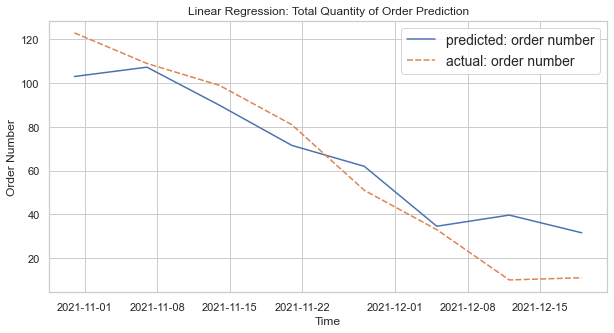

In [21]:
# linear regression result
result_tol.rename(columns = {'predicted':'predicted: order number', 'actual':'actual: order number'}, inplace = True)

sns.set(style = 'whitegrid')
plt.figure(figsize=(10, 5))
plt.rc('legend', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Order Number')
plt.title('Linear Regression: Total Quantity of Order Prediction')
sns.lineplot(data = result_tol)
plt.show()

## Random Forest

In [324]:
data_rf_h = copy.deepcopy(data_lr_h)
data_rf_k = copy.deepcopy(data_lr_k)
data_rf_hi = copy.deepcopy(data_lr_hi)
data_rf_f = copy.deepcopy(data_lr_f)
data_rf_o = copy.deepcopy(data_lr_o)
data_rf = copy.deepcopy(data_lr)

In [325]:
# home
X3h = data_rf_h.drop(['order number'], axis=1)
y3h = data_rf_h['order number']
X3h_train, X3h_test = X3h[:-8], X3h[-8:]
y3h_train, y3h_test = y3h[:-8], y3h[-8:]

# Random Forest
kflodh = KFold(n_splits=10, shuffle = True, random_state=7)

n_estimators = [50,100,200,400]
max_features= np.arange(3, X3h_train.shape[1], 3)
param_grid = dict(n_estimators=n_estimators, max_features=max_features)

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, scoring = 'neg_mean_squared_error', 
                           n_jobs = -1, cv = kflodh)
grid_result = grid_search.fit(X3h_train, y3h_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_search.best_params_))

# fit model
best = pd.DataFrame(grid_search.best_params_,index=range(1))
rfrh = RandomForestRegressor(max_features=best.iloc[0,0], n_estimators=best.iloc[0,1])
rfrh.fit(X3h_train,y3h_train)

Best: -51.590962 using {'max_features': 3, 'n_estimators': 200}


RandomForestRegressor(max_features=3, n_estimators=200)

In [327]:
#predict
y3h_test_predict_rf = rfrh.predict(X3h_test)

# results
y3h_test_predict_rf = pd.Series(y3h_test_predict_rf.tolist(), index=y3h_test.index)
result2h = pd.concat([y2h_test_predict_lm, y3h_test_predict_rf, y3h_test], axis=1)
result2h.columns = ['predict_lm', 'predict_rf', 'actual']
print(result2h)

                predict_lm  predict_rf  actual
departure_date                                
2021-10-31       22.896000      22.510      24
2021-11-07       30.399054      27.300      19
2021-11-14       22.600701      23.065      28
2021-11-21       20.420468      24.215      20
2021-11-28       13.834677      15.050      11
2021-12-05        0.037980       5.195       8
2021-12-12       18.995599       7.440       0
2021-12-19        2.375022       3.860       1


In [328]:
# kitchen
X3k = data_rf_k.drop(['order number'], axis=1)
y3k = data_rf_k['order number']
X3k_train, X3k_test = X3k[:-8], X3k[-8:]
y3k_train, y3k_test = y3k[:-8], y3k[-8:]

# Random Forest
kflodk = KFold(n_splits=10, shuffle = True, random_state=7)

n_estimators = [50,100,200,400]
max_features= np.arange(3, X3k_train.shape[1], 3)
param_grid = dict(n_estimators=n_estimators, max_features=max_features)

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, scoring = 'neg_mean_squared_error', 
                           n_jobs = -1, cv = kflodk)
grid_result = grid_search.fit(X3k_train, y3k_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_search.best_params_))

# fit model
best = pd.DataFrame(grid_search.best_params_,index=range(1))
rfrk = RandomForestRegressor(max_features=best.iloc[0,0], n_estimators=best.iloc[0,1])
rfrk.fit(X3k_train,y3k_train)

Best: -13.261123 using {'max_features': 3, 'n_estimators': 200}


RandomForestRegressor(max_features=3, n_estimators=200)

In [330]:
#predict
y3k_test_predict_rf = rfrk.predict(X3k_test)

# results
y3k_test_predict_rf = pd.Series(y3k_test_predict_rf.tolist(), index=y3k_test.index)
result2k = pd.concat([y2k_test_predict_lm, y3k_test_predict_rf, y3k_test], axis=1)
result2k.columns = ['predict_lm', 'predict_rf', 'actual']
print(result2k)

                predict_lm  predict_rf  actual
departure_date                                
2021-10-31        7.640575    9.390000       9
2021-11-07        6.278564    9.380000      10
2021-11-14        3.677482    5.215000       6
2021-11-21       10.552078    8.018333       8
2021-11-28        9.840976    5.405000       3
2021-12-05        6.321832    4.740000       1
2021-12-12       -0.091024    0.010000       0
2021-12-19       -0.091024    0.010000       0


In [331]:
# home improvement
X3hi = data_rf_hi.drop(['order number'], axis=1)
y3hi = data_rf_hi['order number']
X3hi_train, X3hi_test = X3hi[:-8], X3hi[-8:]
y3hi_train, y3hi_test = y3hi[:-8], y3hi[-8:]

# Random Forest
kflodhi = KFold(n_splits=10, shuffle = True, random_state=7)

n_estimators = [50,100,200,400]
max_features= np.arange(3, X3hi_train.shape[1], 3)
param_grid = dict(n_estimators=n_estimators, max_features=max_features)

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, scoring = 'neg_mean_squared_error', 
                           n_jobs = -1, cv = kflodhi)
grid_result = grid_search.fit(X3hi_train, y3hi_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_search.best_params_))

# fit model
best = pd.DataFrame(grid_search.best_params_,index=range(1))
rfrhi = RandomForestRegressor(max_features=best.iloc[0,0], n_estimators=best.iloc[0,1])
rfrhi.fit(X3hi_train,y3hi_train)

Best: -10.042403 using {'max_features': 3, 'n_estimators': 200}


RandomForestRegressor(max_features=3, n_estimators=200)

In [332]:
#predict
y3hi_test_predict_rf = rfrhi.predict(X3hi_test)

# results
y3hi_test_predict_rf = pd.Series(y3hi_test_predict_rf.tolist(), index=y3hi_test.index)
result2hi = pd.concat([y2hi_test_predict_lm, y3hi_test_predict_rf, y3hi_test], axis=1)
result2hi.columns = ['predict_lm', 'predict_rf', 'actual']
print(result2hi)

                predict_lm  predict_rf  actual
departure_date                                
2021-10-31        8.306070       9.690      14
2021-11-07        9.524454      10.470      13
2021-11-14        8.595317       8.955      10
2021-11-21        5.135045       6.730       9
2021-11-28        4.742019       5.480       5
2021-12-05        0.972187       3.450       1
2021-12-12       10.055219       4.575       1
2021-12-19       10.908293       4.390       1


In [333]:
# furniture
X3f = data_rf_f.drop(['order number'], axis=1)
y3f = data_rf_f['order number']
X3f_train, X3f_test = X3f[:-8], X3f[-8:]
y3f_train, y3f_test = y3f[:-8], y3f[-8:]

# Random Forest
kflodf = KFold(n_splits=10, shuffle = True, random_state=7)

n_estimators = [50,100,200,400]
max_features= np.arange(3, X3f_train.shape[1], 3)
param_grid = dict(n_estimators=n_estimators, max_features=max_features)

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, scoring = 'neg_mean_squared_error', 
                           n_jobs = -1, cv = kflodf)
grid_result = grid_search.fit(X3f_train, y3f_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_search.best_params_))

# fit model
best = pd.DataFrame(grid_search.best_params_,index=range(1))
rfrf = RandomForestRegressor(max_features=best.iloc[0,0], n_estimators=best.iloc[0,1])
rfrf.fit(X3f_train,y3f_train)

Best: -7.561042 using {'max_features': 6, 'n_estimators': 400}


RandomForestRegressor(max_features=6, n_estimators=400)

In [334]:
#predict
y3f_test_predict_rf = rfrf.predict(X3f_test)

# results
y3f_test_predict_rf = pd.Series(y3f_test_predict_rf.tolist(), index=y3f_test.index)
result2f = pd.concat([y2f_test_predict_lm, y3f_test_predict_rf, y3f_test], axis=1)
result2f.columns = ['predict_lm', 'predict_rf', 'actual']
print(result2f)

                predict_lm  predict_rf  actual
departure_date                                
2021-10-31        9.957716      9.3350      13
2021-11-07        5.546423      6.6200       3
2021-11-14        4.354243      3.9150       4
2021-11-21        4.992082      6.3375       2
2021-11-28        4.172003      3.7050       4
2021-12-05        3.971539      2.6775       3
2021-12-12        0.035323      0.0000       0
2021-12-19        5.923097      4.3000       1


In [335]:
# others
X3o = data_rf_o.drop(['order number'], axis=1)
y3o = data_rf_o['order number']
X3o_train, X3o_test = X3o[:-8], X3o[-8:]
y3o_train, y3o_test = y3o[:-8], y3o[-8:]

# Random Forest
kflodo = KFold(n_splits=10, shuffle = True, random_state=7)

n_estimators = [50,100,200,400]
max_features= np.arange(3, X3o_train.shape[1], 3)
param_grid = dict(n_estimators=n_estimators, max_features=max_features)

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, scoring = 'neg_mean_squared_error', 
                           n_jobs = -1, cv = kflodo)
grid_result = grid_search.fit(X3o_train, y3o_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_search.best_params_))

# fit model
best = pd.DataFrame(grid_search.best_params_,index=range(1))
rfro = RandomForestRegressor(max_features=best.iloc[0,0], n_estimators=best.iloc[0,1])
rfro.fit(X3o_train,y3o_train)

Best: -209.224911 using {'max_features': 3, 'n_estimators': 50}


RandomForestRegressor(max_features=3, n_estimators=50)

In [336]:
#predict
y3o_test_predict_rf = rfro.predict(X3o_test)

# results
y3o_test_predict_rf = pd.Series(y3o_test_predict_rf.tolist(), index=y3o_test.index)
result2o = pd.concat([y2o_test_predict_lm, y3o_test_predict_rf, y3o_test], axis=1)
result2o.columns = ['predict_lm', 'predict_rf', 'actual']
print(result2o)

                predict_lm  predict_rf  actual
departure_date                                
2021-10-31       54.244060       55.66      63
2021-11-07       55.552716       58.64      64
2021-11-14       50.696575       49.88      51
2021-11-21       30.431736       45.36      42
2021-11-28       29.371208       30.68      28
2021-12-05       23.256177       25.82      20
2021-12-12       10.572897       16.38       9
2021-12-19       12.359308       32.56       8


In [340]:
# total error analysis
result2_tol = pd.DataFrame()
result2_tol['predicted'] = result2h['predict_rf'] + result2k['predict_rf'] + result2hi['predict_rf'] \
                            + result2f['predict_rf'] + result2o['predict_rf']
result2_tol['actual'] = result2h['actual'] + result2k['actual'] + result2hi['actual'] \
                            + result2f['actual'] + result2o['actual']
result2_tol

,predicted,actual
departure_date,,
2021-10-31,106.585000,123
2021-11-07,112.410000,109
2021-11-14,91.030000,99
2021-11-21,90.660833,81
2021-11-28,60.320000,51
2021-12-05,41.882500,33
2021-12-12,28.405000,10
2021-12-19,45.120000,11


In [341]:
# total rmse & mae
print('Random Forest: ')
print('rmse value for total order number is: ', 
      np.sqrt(mean_squared_error(result2_tol['predicted'], result2_tol['actual'])))
print('mae value for total order number is: ', 
      mean_absolute_error(result2_tol['predicted'], result2_tol['actual']))

Random Forest: 
rmse value for total order number is:  16.22734018926255
mae value for total order number is:  13.522916666666665


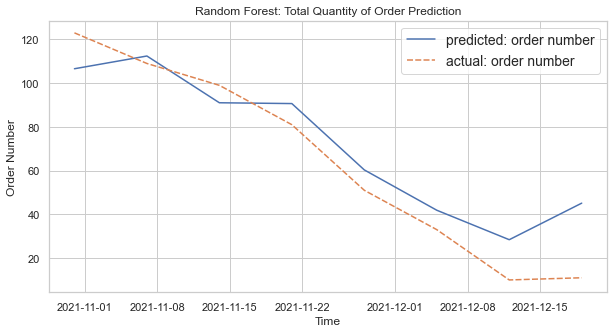

In [343]:
# random forest result
result2_tol.rename(columns = {'predicted':'predicted: order number', 'actual':'actual: order number'}, inplace = True)

sns.set(style = 'whitegrid')
plt.figure(figsize=(10, 5))
plt.rc('legend', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Order Number')
plt.title('Random Forest: Total Quantity of Order Prediction')
sns.lineplot(data = result2_tol)
plt.show()

## ARIMAX

Check R file 'ARIMAX-C.Rmd' for reference

In [344]:
home_x = home
kitchen_x = kitchen
hi_x = hi
furniture_x = furniture
others_x = others
total_x = data

# write time series data to csv
'''
home_x.to_csv('home_x.csv', header = True)
kitchen_x.to_csv('kitchen_x.csv', header = True)
hi_x.to_csv('hi_x.csv', header = True)
furniture_x.to_csv('furniture_x.csv', header = True)
others_x.to_csv('others_x.csv', header = True)
'''